<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/research/notebooks/K7_PINN_Step5_Reconstruction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 5: Full G₂ Holonomy Metric on K₇ via PINN (v3)
## Direct Cholesky Parameterization from Prime-Spectral Data

**GIFT Framework** — Geometric Information Field Theory
**Hardware**: NVIDIA A100-SXM4-80GB (Colab)
**Date**: 2026-02

---

This notebook reconstructs the **explicit 7×7 metric tensor** $g_{ij}(x^1,\ldots,x^7)$ on the compact G₂-holonomy manifold K₇, using a Physics-Informed Neural Network with **direct Cholesky parameterization**: $g = L L^\top$, warm-started at $L_0 = \text{cholesky}(G_\text{target})$ from Step 4.

### Constraints
1. **Determinant**: $\det(g) = 65/32$ (topologically determined)
2. **Torsion**: $\|\nabla\varphi\| \to 0$ (G₂ holonomy)
3. **Anisotropy**: $\|g_\text{mean} - G_\text{target}\|_F \to 0$ (Step 4 structure)
4. **Period integrals**: $\int_{C_k} \varphi = \Pi_k$ for 77 3-cycles
5. **Positive definiteness**: guaranteed by Cholesky $g = LL^\top$

### v3 Key Change
v1/v2 used `14 G₂ adjoint → rank-6 Lie derivatives → 35 φ → g`, constraining the metric
to a 6D subspace of the 28D symmetric perturbation space. The model was stuck at $g = c^2 I_7$.
v3 uses **direct Cholesky** with all 28 DOF, starting at $G_\text{target}$.

### Pipeline Summary
| Step | Content | Status |
|------|---------|--------|
| 1–2 | Mollified Dirichlet polynomial, α=1, 100% counting | ✅ |
| 3 | 77 periods → moduli space (35 local + 42 global) | ✅ |
| 4 | G₂ decomposition, E₈/K3 lattice, metric Jacobian | ✅ |
| **5** | **PINN reconstruction of g_ij(x) — Cholesky v3** | **This notebook** |

## Table of Contents

0. [Header](#)
1. [Setup & Dependencies](#sec1)
2. [GIFT Constants & G₂ Structure](#sec2)
3. [Prime-Spectral Periods](#sec3)
4. [TCS Neck Sampling](#sec4)
5. [PINN Model Architecture](#sec5)
6. [Loss Function (6 Terms, 3 Tiers)](#sec6)
7. [Training Infrastructure](#sec7)
8. [Training Execution (3 Phases)](#sec8)
9. [Evaluation & Metric Extraction](#sec9)
10. [Visualization (8 Figures)](#sec10)
11. [Export (JSON + npy + pt)](#sec11)
12. [Summary & Conclusions](#sec12)

---
## 1. Setup & Dependencies <a id='sec1'></a>

In [15]:
# Cell 1.1: Install dependencies
!pip install -q torch numpy scipy matplotlib tqdm
try:
    import cupy as cp
    print(f'CuPy already installed: {cp.__version__}')
except ImportError:
    !pip install -q cupy-cuda12x
    import cupy as cp
    print(f'CuPy installed: {cp.__version__}')

CuPy already installed: 13.6.0


In [16]:
# Cell 1.2: Imports and GPU detection
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json, os, time, gc, warnings
from itertools import combinations
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')

# GPU detection
try:
    import cupy as cp
    from cupyx.scipy.sparse import csr_matrix as cp_csr
    from cupyx.scipy.sparse.linalg import eigsh as cp_eigsh
    GPU_AVAILABLE = True
    gpu_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode()
    gpu_mem = cp.cuda.runtime.getDeviceProperties(0)['totalGlobalMem'] / 1e9
    print(f'GPU: {gpu_name} ({gpu_mem:.0f} GB)')
except Exception as e:
    GPU_AVAILABLE = False
    print(f'No GPU/CuPy: {e}. Using CPU fallback.')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)
print(f'PyTorch device: {DEVICE}')
print(f'Default dtype: {DTYPE}')

def clear_gpu():
    """Free all GPU memory pools."""
    gc.collect()
    if GPU_AVAILABLE:
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    torch.cuda.empty_cache()

GPU: NVIDIA A100-SXM4-80GB (85 GB)
PyTorch device: cuda
Default dtype: torch.float64


In [17]:
# Cell 1.3: Download data from repository
import urllib.request

BASE_URL = 'https://raw.githubusercontent.com/gift-framework/GIFT/research/notebooks'
RIEMANN_URL = f'{BASE_URL}/riemann'
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

def download(url, path):
    if not os.path.exists(path):
        print(f'  Downloading {os.path.basename(path)}...')
        try:
            urllib.request.urlretrieve(url, path)
        except Exception as e:
            print(f'  Failed: {e}')
            return False
    return True

# Download pre-computed results (Step 3-4)
json_files = [
    'moduli_reconstruction_results.json',
    'harmonic_forms_results.json',
    'heat_kernel_results.json',
]
step_data = {}
for fname in json_files:
    path = os.path.join(DATA_DIR, fname)
    if download(f'{RIEMANN_URL}/{fname}', path):
        try:
            with open(path) as f:
                step_data[fname.replace('_results.json', '')] = json.load(f)
            print(f'  Loaded {fname}')
        except Exception as e:
            print(f'  Parse error: {e}')

# Riemann zeros: LFS-tracked, not downloadable via raw.githubusercontent.com
# Not needed for Step 5 (periods are computed analytically from prime formula)
GAMMA = None
zeros_path = os.path.join(DATA_DIR, 'riemann_zeros_100k_genuine.npy')
if os.path.exists(zeros_path):
    try:
        GAMMA = np.load(zeros_path)
        print(f'  Loaded {len(GAMMA):,} Riemann zeros (local cache)')
    except:
        print('  Could not load cached zeros (not needed for Step 5)')
else:
    print('  Riemann zeros: skipped (LFS file, not needed for Step 5 training)')

print(f'\nData loaded: {len(step_data)} JSON files')

  Loaded moduli_reconstruction_results.json
  Loaded harmonic_forms_results.json
  Loaded heat_kernel_results.json
  Riemann zeros: skipped (LFS file, not needed for Step 5 training)

Data loaded: 3 JSON files


---
## 2. GIFT Constants & G₂ Structure <a id='sec2'></a>

In [18]:
# Cell 2.1: Topological constants
DIM = 7
DIM_G2 = 14
B2, B3 = 21, 77
H_STAR = 99
KAPPA_T = 1.0 / 61
DET_G = 65.0 / 32.0
LAMBDA1 = 14.0 / 99.0
N_GEN = 3

# TCS building blocks
B2_M1, B3_M1 = 11, 40   # quintic in CP4
B2_M2, B3_M2 = 10, 37   # CI(2,2,2) in CP6
TCS_R1, TCS_R2 = 33, 28  # TCS ratio: H*/(6*dim_G2) ≈ 33/28

# Fano plane triples (octonion multiplication)
FANO_TRIPLES = [(0,1,2), (0,3,4), (0,5,6), (1,3,5), (1,4,6), (2,3,6), (2,4,5)]
FANO_SIGNS   = [+1,      +1,      +1,      +1,      -1,      -1,      -1     ]

# All C(7,3) = 35 triples
ALL_TRIPLES = list(combinations(range(DIM), 3))
TRIPLE_INDEX = {t: i for i, t in enumerate(ALL_TRIPLES)}

print(f'K7 topology: dim={DIM}, b2={B2}, b3={B3}, H*={H_STAR}')
print(f'Target: det(g)={DET_G}, lambda1={LAMBDA1:.6f}, kappa_T={KAPPA_T:.6f}')
print(f'TCS: M1(b2={B2_M1},b3={B3_M1}) + M2(b2={B2_M2},b3={B3_M2})')

K7 topology: dim=7, b2=21, b3=77, H*=99
Target: det(g)=2.03125, lambda1=0.141414, kappa_T=0.016393
TCS: M1(b2=11,b3=40) + M2(b2=10,b3=37)


In [19]:
# Cell 2.2: Build standard associative 3-form phi0

def build_phi0_components():
    """35-component vector of the standard associative 3-form."""
    phi = np.zeros(35, dtype=np.float64)
    for (i,j,k), s in zip(FANO_TRIPLES, FANO_SIGNS):
        phi[TRIPLE_INDEX[(i,j,k)]] = s
    return phi

def build_phi0_tensor():
    """Full 7x7x7 antisymmetric tensor."""
    phi = build_phi0_components()
    T = np.zeros((DIM, DIM, DIM), dtype=np.float64)
    for idx, (i,j,k) in enumerate(ALL_TRIPLES):
        val = phi[idx]
        T[i,j,k] = val;  T[j,k,i] = val;  T[k,i,j] = val
        T[i,k,j] = -val; T[k,j,i] = -val; T[j,i,k] = -val
    return T

PHI0_COMPS = build_phi0_components()
PHI0_TENSOR = build_phi0_tensor()

# Scale factor for det(g) = 65/32
C_REF = DET_G ** (1.0 / 14.0)  # phi_ref = C_REF * phi0

# Verify: metric from phi0 = I_7
g0 = np.einsum('ikl,jkl->ij', PHI0_TENSOR, PHI0_TENSOR) / 6.0
assert np.allclose(g0, np.eye(DIM)), f'g0 from phi0 is not I_7!\n{g0}'
print(f'phi0: {np.count_nonzero(PHI0_COMPS)} nonzero / 35, ||phi0|| = {np.linalg.norm(PHI0_COMPS):.6f}')
print(f'c_ref = (65/32)^(1/14) = {C_REF:.6f}')
print(f'g_ref = {C_REF**2:.6f} * I_7, det(g_ref) = {C_REF**14:.6f}')

phi0: 7 nonzero / 35, ||phi0|| = 2.645751
c_ref = (65/32)^(1/14) = 1.051921
g_ref = 1.106538 * I_7, det(g_ref) = 2.031250


In [20]:
# Cell 2.3: G2 generators and Lie derivatives

def g2_generators():
    """14 generators of G2 in so(7)."""
    gens = np.zeros((14, DIM, DIM), dtype=np.float64)
    # First 7: rotations in Fano planes
    for idx, (i,j,k) in enumerate(FANO_TRIPLES):
        gens[idx, i, j] = 1; gens[idx, j, i] = -1
    # Remaining 7: mixed rotations
    for idx in range(7):
        i, j, k = idx, (idx+1) % 7, (idx+3) % 7
        gens[7+idx, i, k] = 1;   gens[7+idx, k, i] = -1
        gens[7+idx, j, k] = 0.5; gens[7+idx, k, j] = -0.5
    # Normalize
    for idx in range(14):
        norm = np.linalg.norm(gens[idx])
        if norm > 1e-10:
            gens[idx] /= norm
    return gens

def precompute_lie_derivatives():
    """Lie derivatives of phi0 along G2 generators: 14 x 35 matrix."""
    gens = g2_generators()
    L = np.zeros((14, 35), dtype=np.float64)
    for a in range(14):
        X = gens[a]
        idx = 0
        for i in range(DIM):
            for j in range(i+1, DIM):
                for k in range(j+1, DIM):
                    val = sum(X[i,l]*PHI0_TENSOR[l,j,k] + X[j,l]*PHI0_TENSOR[i,l,k]
                              + X[k,l]*PHI0_TENSOR[i,j,l] for l in range(DIM))
                    L[a, idx] = val
                    idx += 1
    return L

G2_GENS = g2_generators()
LIE_DERIVS = precompute_lie_derivatives()
print(f'G2 generators: {G2_GENS.shape} (14 elements of so(7))')
print(f'Lie derivatives: {LIE_DERIVS.shape} (14 x 35 matrix)')
print(f'Rank of Lie derivative matrix: {np.linalg.matrix_rank(LIE_DERIVS)}')

G2 generators: (14, 7, 7) (14 elements of so(7))
Lie derivatives: (14, 35) (14 x 35 matrix)
Rank of Lie derivative matrix: 6


In [21]:
# Cell 2.4: G2 decomposition verification

# Verify Lambda^3 = 1 + 7 + 27
phi0_norm = np.linalg.norm(PHI0_COMPS)
e1 = PHI0_COMPS / phi0_norm  # unit vector along Lambda^3_1

# Lambda^3_7 from coassociative 4-form contraction
# (already verified in Step 4)

# Projection of Fano-aligned forms
fano_idx = [TRIPLE_INDEX[t] for t in FANO_TRIPLES]
non_fano_idx = [i for i in range(35) if i not in fano_idx]

proj_1 = np.array([e1[k]**2 for k in range(35)])
print(f'G2 decomposition: Lambda^3 = 1 + 7 + 27 = 35')
print(f'  Fano projection onto Lambda^3_1: {proj_1[fano_idx[0]]:.4f} each (=1/7)')
print(f'  Non-Fano projection: {proj_1[non_fano_idx[0]]:.4f} (=0)')
print(f'\nModuli: 77 = 1 (volume) + 0 (gauge, b1=0) + 76 (shape)')

G2 decomposition: Lambda^3 = 1 + 7 + 27 = 35
  Fano projection onto Lambda^3_1: 0.1429 each (=1/7)
  Non-Fano projection: 0.0000 (=0)

Moduli: 77 = 1 (volume) + 0 (gauge, b1=0) + 76 (shape)


---
## 3. Prime-Spectral Periods <a id='sec3'></a>

In [22]:
# Cell 3.1: Prime sieve and period map

def sieve(N):
    is_p = np.ones(N+1, dtype=bool); is_p[:2] = False
    for i in range(2, int(N**0.5)+1):
        if is_p[i]: is_p[i*i::i] = False
    return list(np.where(is_p)[0])

PRIMES_77 = sieve(400)[:B3]  # first 77 primes: 2, 3, ..., 389

THETA_0, THETA_1 = 1.4091, -3.9537  # Adaptive cutoff parameters

def period_map(T, primes=PRIMES_77):
    """Compute 77 prime periods Pi_k(T)."""
    log_X = THETA_0 * np.log(T) + THETA_1
    if log_X < 0.5:
        log_X = 0.5
    Pi = np.zeros(len(primes))
    for k, p in enumerate(primes):
        logp = np.log(float(p))
        x = logp / log_X
        w = np.cos(np.pi * x / 2.0)**2 if x < 1 else 0.0
        Pi[k] = KAPPA_T * w / np.sqrt(float(p))
    return Pi

print(f'77 primes: {PRIMES_77[0]}, {PRIMES_77[1]}, ..., {PRIMES_77[-1]}')
print(f'Adaptive cutoff: theta(T) = {THETA_0} + {THETA_1}/log(T)')

77 primes: 2, 3, ..., 389
Adaptive cutoff: theta(T) = 1.4091 + -3.9537/log(T)


In [23]:
# Cell 3.2: Compute periods at multiple scales

T_SCALES = [100, 1000, 10000, 40000, 75000]
T_REF = 40434.2

PERIODS = {}
for T in T_SCALES + [T_REF]:
    Pi = period_map(T)
    PERIODS[T] = Pi

Pi_ref = PERIODS[T_REF]
print(f'Reference scale T = {T_REF:.0f}:')
print(f'  ||Pi||_2 = {np.linalg.norm(Pi_ref):.6f}')
print(f'  Local (35):  ||Pi_L|| = {np.linalg.norm(Pi_ref[:35]):.6f}')
print(f'  Global M1:   ||Pi_G1|| = {np.linalg.norm(Pi_ref[35:56]):.6f}')
print(f'  Global M2:   ||Pi_G2|| = {np.linalg.norm(Pi_ref[56:]):.6f}')
print(f'\nPeriods at {len(T_SCALES)} scales computed.')

# Convert to torch tensors
PI_TARGETS = {T: torch.tensor(Pi, dtype=DTYPE, device=DEVICE) for T, Pi in PERIODS.items()}

Reference scale T = 40434:
  ||Pi||_2 = 0.020596
  Local (35):  ||Pi_L|| = 0.020311
  Global M1:   ||Pi_G1|| = 0.002816
  Global M2:   ||Pi_G2|| = 0.001926

Periods at 5 scales computed.


In [24]:
# Cell 3.3: Period evolution table

print(f'{"T":>8s} | {"||Pi||":>8s} | {"||local||":>10s} | {"||global||":>10s} | {"#active":>7s}')
print(f'{"-"*8}-+-{"-"*8}-+-{"-"*10}-+-{"-"*10}-+-{"-"*7}')
for T in sorted(PERIODS.keys()):
    Pi = PERIODS[T]
    n_active = np.sum(np.abs(Pi) > 1e-10)
    print(f'{T:8.0f} | {np.linalg.norm(Pi):8.5f} | {np.linalg.norm(Pi[:35]):10.6f} | '
          f'{np.linalg.norm(Pi[35:]):10.6f} | {n_active:7d}')

       T |   ||Pi|| |  ||local|| | ||global|| | #active
---------+----------+------------+------------+--------
     100 |  0.01139 |   0.011393 |   0.000000 |       5
    1000 |  0.01702 |   0.017019 |   0.000123 |      66
   10000 |  0.01962 |   0.019482 |   0.002296 |      77
   40000 |  0.02059 |   0.020306 |   0.003404 |      77
   40434 |  0.02060 |   0.020311 |   0.003412 |      77
   75000 |  0.02093 |   0.020580 |   0.003794 |      77


---
## 4. TCS Neck Sampling <a id='sec4'></a>

In [25]:
# Cell 4.1: Sampling functions

def sample_S3(n, device=DEVICE):
    """Uniform sampling on S3 via Gaussian normalization."""
    x = torch.randn(n, 4, device=device, dtype=DTYPE)
    return x / x.norm(dim=-1, keepdim=True)

def sample_tcs_neck(n, r1=TCS_R1, r2=TCS_R2, device=DEVICE):
    """
    Sample from TCS neck S1 x S3 x S3.
    Returns (n, 7) coordinates + full quaternions for distance computation.
    """
    theta = 2 * np.pi * torch.rand(n, 1, device=device, dtype=DTYPE)
    q1 = sample_S3(n, device)
    q2 = sample_S3(n, device)
    # Stereographic projection to get 3D from each S3
    q1_3d = q1[:, 1:4] / (1 + q1[:, 0:1].abs() + 1e-8)
    q2_3d = q2[:, 1:4] / (1 + q2[:, 0:1].abs() + 1e-8)
    coords = torch.cat([theta, q1_3d, q2_3d], dim=-1)  # (n, 7)
    return coords, q1, q2

def geodesic_dist_S3(q1, q2):
    """Geodesic distance on S3 (quaternionic)."""
    dot = torch.abs(torch.sum(q1 * q2, dim=-1))
    dot = torch.clamp(dot, 0, 1)
    return torch.arccos(dot)

# Test sampling
x_test, q1_test, q2_test = sample_tcs_neck(1000)
print(f'TCS neck sampling: {x_test.shape}')
print(f'  Coordinate ranges:')
for i, name in enumerate(['theta', 'q1_x', 'q1_y', 'q1_z', 'q2_x', 'q2_y', 'q2_z']):
    print(f'    {name}: [{x_test[:,i].min():.3f}, {x_test[:,i].max():.3f}]')

TCS neck sampling: torch.Size([1000, 7])
  Coordinate ranges:
    theta: [0.001, 6.283]
    q1_x: [-0.966, 0.929]
    q1_y: [-0.932, 0.970]
    q1_z: [-0.974, 0.949]
    q2_x: [-0.964, 0.950]
    q2_y: [-0.961, 0.916]
    q2_z: [-0.957, 0.958]


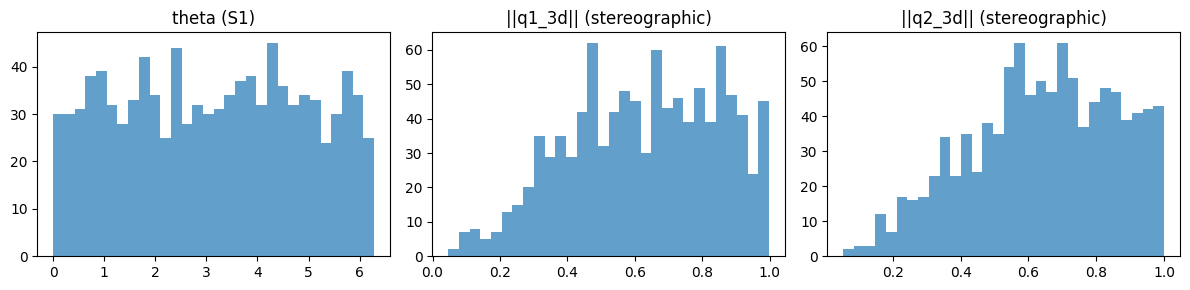

Sampling OK.


In [26]:
# Cell 4.2: Verify sampling distribution

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(x_test[:,0].cpu().numpy(), bins=30, alpha=0.7)
axes[0].set_title('theta (S1)')
axes[1].hist(torch.norm(x_test[:,1:4], dim=-1).cpu().numpy(), bins=30, alpha=0.7)
axes[1].set_title('||q1_3d|| (stereographic)')
axes[2].hist(torch.norm(x_test[:,4:7], dim=-1).cpu().numpy(), bins=30, alpha=0.7)
axes[2].set_title('||q2_3d|| (stereographic)')
plt.tight_layout()
plt.savefig('sampling_check.png', dpi=100)
plt.show()
print('Sampling OK.')

---
## 5. PINN Model Architecture (v3 — Direct Cholesky) <a id='sec5'></a>

**v3 key change**: Abandon the indirect `φ → g` pathway (rank-6 Lie derivative bottleneck)
in favor of **direct Cholesky parameterization** of the metric.

```
Input: (x1,...,x7, log T) ∈ ℝ⁸
  ↓
FourierFeatures(48 freq) → ℝ⁹⁶
  ↓
MLP: 96 → 256 → 256 → 256 → 128
  ↓
┌─ Metric head: 128 → 28 (lower triangular δL)
│    L(x) = L₀ + δL(x)
│    g(x) = L(x) L(x)ᵀ   ← automatically PD + symmetric
│    L₀ = cholesky(G_TARGET)  ← warm-start at Step 4 answer
│
└─ 3-form heads: 128 → 35 (local φ) + 42 (global TCS)
     φ = c·φ₀ + 0.1·δφ    ← for periods + torsion
```

**Why v3?** v1/v2 used `14 G₂ adjoint → rank-6 Lie derivatives → 35 φ → g`, which
constrains the metric to a 6D subspace of the 28D space of symmetric 7×7 perturbations.
The model was stuck at `g = c²·I₇` despite 97.6% of the loss gradient coming from the
anisotropy term. Direct Cholesky gives 28 free metric DOF per point and starts at `G_TARGET`.

In [27]:
# Cell 5.1: FourierFeatures

class FourierFeatures(nn.Module):
    """Random Fourier feature encoding for periodic structure."""
    def __init__(self, input_dim=8, num_frequencies=48, scale=2.0):
        super().__init__()
        self.output_dim = 2 * num_frequencies
        B = torch.randn(num_frequencies, input_dim, dtype=DTYPE) * scale
        self.register_buffer('B', B)

    def forward(self, x):
        projected = 2 * np.pi * torch.matmul(x, self.B.T)
        return torch.cat([torch.cos(projected), torch.sin(projected)], dim=-1)

In [28]:
# Cell 5.2: CholeskyMetricPINN model (v3)

# --- FIX: Move G_TARGET_NP definition here from Cell 6.3 ---
if 'harmonic_forms' in step_data and 'full_metric' in step_data['harmonic_forms']:
    G_TARGET_RAW = np.array(step_data['harmonic_forms']['full_metric']['g_full_matrix'])
    det_raw = np.linalg.det(G_TARGET_RAW)
    rescale = (DET_G / det_raw) ** (1.0 / DIM)
    G_TARGET_NP = rescale * G_TARGET_RAW
    print(f'Target metric loaded: det={np.linalg.det(G_TARGET_NP):.6f}')
else:
    G_TARGET_NP = C_REF**2 * np.eye(DIM)
    print('Target metric fallback: isotropic')

G_TARGET = torch.tensor(G_TARGET_NP, dtype=DTYPE, device=DEVICE)
# -----------------------------------------------------------

class CholeskyMetricPINN(nn.Module):
    """
    Physics-Informed Neural Network for G2 holonomy metric on K7.

    v3: Direct Cholesky parameterization g = L @ L^T
    - 28 free metric DOF per point (lower triangular 7x7)
    - Warm-started at L0 = cholesky(G_TARGET) from Step 4
    - Automatically PD and symmetric (no L_pd loss needed)
    - Separate 3-form heads for period integrals and torsion
    """
    def __init__(self, n_freq=48, hidden=[256, 256, 256, 128],
                 phi_scale=0.1, include_scale=True):
        super().__init__()
        self.phi_scale = phi_scale
        self.include_scale = include_scale
        input_dim = 8 if include_scale else 7

        # Cholesky of target metric: L0 @ L0^T = G_TARGET
        L0 = np.linalg.cholesky(G_TARGET_NP)
        tril_idx = np.tril_indices(DIM)
        L0_flat = L0[tril_idx]  # 28 entries
        self.register_buffer('L0_flat', torch.tensor(L0_flat, dtype=DTYPE))
        self.register_buffer('tril_row', torch.tensor(tril_idx[0], dtype=torch.long))
        self.register_buffer('tril_col', torch.tensor(tril_idx[1], dtype=torch.long))

        # Reference 3-form (for periods)
        self.register_buffer('phi0_comps', torch.tensor(C_REF * PHI0_COMPS, dtype=DTYPE))

        # Fourier features
        self.fourier = FourierFeatures(input_dim=input_dim, num_frequencies=n_freq)

        # Shared backbone
        layers = []
        in_dim = self.fourier.output_dim
        for h_dim in hidden:
            layers.extend([nn.Linear(in_dim, h_dim), nn.SiLU()])
            in_dim = h_dim
        self.backbone = nn.Sequential(*layers)

        # Metric head: backbone -> 28 (lower triangular perturbation delta_L)
        self.metric_head = nn.Linear(hidden[-1], 28)

        # 3-form heads (for periods + torsion, decoupled from metric)
        self.local_head = nn.Linear(hidden[-1], 35)   # local phi perturbation
        self.global_head = nn.Linear(hidden[-1], 42)   # global TCS modes

        self._init_weights()

    def _init_weights(self):
        """Initialize near-zero output so g ≈ G_TARGET at init."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _make_input(self, x, log_T=None):
        """Append log(T) as 8th dimension if needed."""
        if self.include_scale and log_T is not None:
            T_col = torch.full((x.shape[0], 1), log_T, device=x.device, dtype=DTYPE)
            return torch.cat([x, T_col], dim=-1)
        elif self.include_scale:
            T_col = torch.full((x.shape[0], 1), np.log(T_REF), device=x.device, dtype=DTYPE)
            return torch.cat([x, T_col], dim=-1)
        return x

    def forward(self, x, log_T=None):
        """Return (phi_local_35, phi_global_42, delta_L_28).

        First two returns are 3-form components (compatible with v2 torsion loss).
        Third return is the Cholesky perturbation.
        """
        inp = self._make_input(x, log_T)
        h = self.backbone(self.fourier(inp))

        # 3-form: phi_ref + perturbation (for periods + torsion)
        delta_local = self.local_head(h)      # (N, 35)
        delta_global = self.global_head(h)    # (N, 42)
        local_comps = self.phi0_comps.unsqueeze(0) + self.phi_scale * delta_local
        global_comps = self.phi_scale * delta_global

        # Metric: Cholesky perturbation
        delta_L = self.metric_head(h)          # (N, 28)

        return local_comps, global_comps, delta_L

    def cholesky_L(self, x, log_T=None):
        """Build L = L0 + delta_L as (N, 7, 7) lower triangular matrix."""
        _, _, delta_L = self.forward(x, log_T)
        N = x.shape[0]
        L = torch.zeros(N, DIM, DIM, device=x.device, dtype=DTYPE)
        L_flat = self.L0_flat.unsqueeze(0) + delta_L   # (N, 28)
        L[:, self.tril_row, self.tril_col] = L_flat
        return L

    def metric(self, x, log_T=None):
        """g = L @ L^T — automatically PD and symmetric."""
        L = self.cholesky_L(x, log_T)
        return torch.bmm(L, L.transpose(1, 2))

    def det_g(self, x, log_T=None):
        """det(g) = det(L)^2 = prod(diag(L))^2."""
        L = self.cholesky_L(x, log_T)
        diag_L = L[:, range(DIM), range(DIM)]
        return torch.prod(diag_L ** 2, dim=-1)

    def moduli_77(self, x, log_T=None):
        """Return all 77 moduli components as a single vector."""
        local, glob, _ = self.forward(x, log_T)
        delta_local = local - self.phi0_comps.unsqueeze(0)
        return torch.cat([delta_local, glob], dim=-1)  # (N, 77)

# Instantiate and report
model = CholeskyMetricPINN().to(DEVICE)
n_params = sum(p.numel() for p in model.parameters())
print(f'CholeskyMetricPINN: {n_params:,} parameters')
print(f'  Backbone: FourierFeatures(48) -> MLP(256,256,256,128)')
print(f'  Metric head: 128 -> 28 (Cholesky lower triangular)')
print(f'  Local head: 128 -> 35 (phi perturbation, for periods)')
print(f'  Global head: 128 -> 42 (TCS modes, for periods)')
print(f'  Warm-start: L0 = cholesky(G_TARGET), det(G_TARGET) = {np.linalg.det(G_TARGET_NP):.6f}')

# Quick test
with torch.no_grad():
    x_test = sample_tcs_neck(100)[0]
    g_test = model.metric(x_test)
    det_test = torch.linalg.det(g_test)
    g_mean_init = g_test.mean(dim=0).cpu().numpy()
    aniso_init = np.linalg.norm(g_mean_init - G_TARGET_NP)
    print(f'\nQuick test (100 points):')
    print(f'  det(g) mean: {det_test.mean():.6f} (target: {DET_G:.6f})')
    print(f'  det(g) std:  {det_test.std():.6f}')
    print(f'  ||g_mean - G_TARGET||_F: {aniso_init:.6f} (should be ~0 at init)')
    print(f'  Condition: {(torch.linalg.eigvalsh(g_test).max(dim=-1).values / torch.linalg.eigvalsh(g_test).min(dim=-1).values).mean():.6f}')

Target metric loaded: det=2.031250
CholeskyMetricPINN: 202,857 parameters
  Backbone: FourierFeatures(48) -> MLP(256,256,256,128)
  Metric head: 128 -> 28 (Cholesky lower triangular)
  Local head: 128 -> 35 (phi perturbation, for periods)
  Global head: 128 -> 42 (TCS modes, for periods)
  Warm-start: L0 = cholesky(G_TARGET), det(G_TARGET) = 2.031250

Quick test (100 points):
  det(g) mean: 2.031250 (target: 2.031250)
  det(g) std:  0.000000
  ||g_mean - G_TARGET||_F: 0.000000 (should be ~0 at init)
  Condition: 1.015178


---
## 6. Loss Function (v3 — Cholesky) <a id='sec6'></a>

Two tiers:
- **Tier 1** (every batch): determinant, torsion, sparsity
- **Tier 2** (every batch): multi-scale period matching (5 scales) + anisotropy (Step 4 target metric)

**v3 changes vs v2:**
- **Removed `L_pd`**: Cholesky parameterization `g = LLᵀ` guarantees positive-definiteness
- **Updated `L_sparse`**: regularizes `δL` (Cholesky perturbation) instead of G₂ adjoint params
- **Same anisotropy + period losses**: these worked architecturally, the issue was metric expressivity
- $\lambda_1 = 14/99$ remains a post-hoc diagnostic (global property, not trainable locally)

In [29]:
# Cell 6.1: Tier 1 — Pointwise losses (v3: no L_pd, updated L_sparse)

def loss_determinant(model, x, log_T=None):
    """L_det = (det(g) - 65/32)^2."""
    det_g = model.det_g(x, log_T)
    return torch.mean((det_g - DET_G) ** 2)

def loss_torsion(model, x, log_T=None):
    """Torsion proxy: penalize spatial variation of phi (3-form head)."""
    eps = 0.01
    local_0, _, _ = model.forward(x, log_T)
    torsion = 0.0
    for dim in range(DIM):
        x_plus = x.clone()
        x_plus[:, dim] += eps
        local_plus, _, _ = model.forward(x_plus, log_T)
        dphi = (local_plus - local_0) / eps
        torsion += (dphi ** 2).mean()
    return torsion / DIM

def loss_sparse(model, x, log_T=None):
    """L_sparse = ||delta_L||^2 (regularize Cholesky perturbation)."""
    _, _, delta_L = model.forward(x, log_T)
    return torch.mean(delta_L ** 2)

In [30]:
# Cell 6.2: Tier 2a — Period loss (multi-scale)

def loss_periods(model, x, T_val=T_REF, log_T=None):
    """Period loss at a single scale."""
    if log_T is None:
        log_T = np.log(T_val)
    moduli = model.moduli_77(x, log_T)  # (N, 77)
    Pi_target = PI_TARGETS[T_val]       # (77,)
    moduli_mean = moduli.mean(dim=0)    # (77,)
    return torch.mean((moduli_mean - Pi_target) ** 2)

def loss_periods_multiscale(model, x):
    """Period loss averaged over all 5 energy scales simultaneously.

    Same batch of TCS points, different log(T) → different moduli targets.
    This trains the scale dimension of the PINN.
    """
    total = torch.tensor(0.0, device=DEVICE, dtype=DTYPE)
    for T in T_SCALES:
        moduli = model.moduli_77(x, np.log(T)).mean(dim=0)
        target = PI_TARGETS[T]
        total = total + torch.mean((moduli - target) ** 2)
    return total / len(T_SCALES)

In [31]:
# Cell 6.3: Tier 2b — Anisotropy loss (Step 4 target metric)

# Load and rescale Step 4 target metric to have det = 65/32
if 'harmonic_forms' in step_data and 'full_metric' in step_data['harmonic_forms']:
    G_TARGET_RAW = np.array(step_data['harmonic_forms']['full_metric']['g_full_matrix'])
    det_raw = np.linalg.det(G_TARGET_RAW)
    # Rescale: det(s*A) = s^7 * det(A), so s = (DET_G/det_raw)^(1/7)
    rescale = (DET_G / det_raw) ** (1.0 / DIM)
    G_TARGET_NP = rescale * G_TARGET_RAW
    HAS_TARGET = True
    eigs_tgt = np.linalg.eigvalsh(G_TARGET_NP)
    print(f'Step 4 target metric loaded and rescaled:')
    print(f'  Original det = {det_raw:.6f}, rescaled det = {np.linalg.det(G_TARGET_NP):.6f}')
    print(f'  Rescale factor: {rescale:.6f}')
    print(f'  Condition number: {eigs_tgt.max()/eigs_tgt.min():.6f}')
    print(f'  Diagonal: [{", ".join(f"{v:.5f}" for v in np.diag(G_TARGET_NP))}]')
    offdiag_max = np.max(np.abs(G_TARGET_NP - np.diag(np.diag(G_TARGET_NP))))
    print(f'  Off-diagonal max: {offdiag_max:.6f}')
else:
    # Fallback: isotropic metric (anisotropy loss will be zero — no signal)
    G_TARGET_NP = C_REF**2 * np.eye(DIM)
    HAS_TARGET = False
    print('WARNING: Step 4 data not available. Using isotropic fallback.')

G_TARGET = torch.tensor(G_TARGET_NP, dtype=DTYPE, device=DEVICE)


def loss_anisotropy(model, x, log_T=None):
    """Match spatial average of metric to Step 4 target structure.

    The target encodes the Fano-plane anisotropy from Step 4:
    - 7 Fano-aligned modes: Tr(dg/dPi) = ±2.104 (volume-changing)
    - 28 non-Fano modes: traceless (pure shape)
    - Off-diagonal elements ~0.003 encode cross-coupling
    """
    if log_T is None:
        log_T = np.log(T_REF)
    g = model.metric(x, log_T)  # (N, 7, 7) — with gradients
    g_mean = g.mean(dim=0)      # (7, 7)
    return torch.sum((g_mean - G_TARGET) ** 2)


# Post-hoc spectral evaluation (diagnostic only, not for training)
def evaluate_spectral_posthoc(model, n_samples=5000):
    """
    Rayleigh quotient on TCS neck — diagnostic purposes only.

    NOTE: This measures the LOCAL spectral gap on the coordinate patch,
    not the global lambda1 of compact K7. The global value (14/99)
    depends on the full manifold topology and cannot be computed locally.
    """
    x, _, _ = sample_tcs_neck(n_samples)
    with torch.no_grad():
        g = model.metric(x)
        g_inv = torch.linalg.inv(g)
        det_g = torch.linalg.det(g)
        sqrt_det = torch.sqrt(torch.abs(det_g) + 1e-10)

    rayleigh_values = []
    for dim_idx in range(DIM):
        for freq in [1, 2, 3]:
            f = torch.cos(freq * x[:, dim_idx])
            f = f - f.mean()
            if f.var() < 1e-10:
                continue
            grad_f = torch.zeros(n_samples, DIM, device=x.device, dtype=DTYPE)
            grad_f[:, dim_idx] = -freq * torch.sin(freq * x[:, dim_idx])
            grad_f_norm_sq = torch.einsum('ni,nij,nj->n', grad_f, g_inv, grad_f)
            R = float((grad_f_norm_sq * sqrt_det).mean() / ((f**2 * sqrt_det).mean() + 1e-10))
            rayleigh_values.append(R)

    for i in range(DIM):
        for j in range(i+1, min(i+3, DIM)):
            f = torch.cos(x[:, i]) * torch.cos(x[:, j])
            f = f - f.mean()
            if f.var() < 1e-10:
                continue
            grad_f = torch.zeros(n_samples, DIM, device=x.device, dtype=DTYPE)
            grad_f[:, i] = -torch.sin(x[:, i]) * torch.cos(x[:, j])
            grad_f[:, j] = -torch.cos(x[:, i]) * torch.sin(x[:, j])
            grad_f_norm_sq = torch.einsum('ni,nij,nj->n', grad_f, g_inv, grad_f)
            R = float((grad_f_norm_sq * sqrt_det).mean() / ((f**2 * sqrt_det).mean() + 1e-10))
            rayleigh_values.append(R)

    if rayleigh_values:
        vals = sorted(rayleigh_values)
        return vals[0], vals[:5]
    return 0.0, []


# Quick tests
with torch.no_grad():
    x_test = sample_tcs_neck(500)[0]
    L_a = loss_anisotropy(model, x_test)
    print(f'\nInitial anisotropy loss: {float(L_a):.6f}')
    print(f'  => Weighted (×500): {float(L_a) * 500:.4f}')

    lam1, _ = evaluate_spectral_posthoc(model, n_samples=500)
    print(f'\nLocal Rayleigh quotient (diagnostic only):')
    print(f'  lambda1_local = {lam1:.4f}, lambda1_local * H* = {lam1*99:.1f}')
    print(f'  Global prediction: lambda1 = 14/99 = {LAMBDA1:.4f} (topological, not trained)')

Step 4 target metric loaded and rescaled:
  Original det = 2.085025, rescaled det = 2.031250
  Rescale factor: 0.996274
  Condition number: 1.015178
  Diagonal: [1.11332, 1.11055, 1.10908, 1.10430, 1.10263, 1.10385, 1.10217]
  Off-diagonal max: 0.004613

Initial anisotropy loss: 0.000000
  => Weighted (×500): 0.0000

Local Rayleigh quotient (diagnostic only):
  lambda1_local = 0.8880, lambda1_local * H* = 87.9
  Global prediction: lambda1 = 14/99 = 0.1414 (topological, not trained)


In [32]:
# Cell 6.4: Loss weights (v3 — Cholesky, no L_pd)

LOSS_WEIGHTS = {
    'det': 100.0,       # Determinant = 65/32
    'torsion': 1.0,     # Torsion proxy (spatial gradient penalty on 3-form)
    'sparse': 0.01,     # Regularization of Cholesky perturbation delta_L
    'period': 1000.0,   # Period integrals at 5 scales
    'aniso': 500.0,     # Step 4 target metric structure
}

print('Loss weights (v3):')
for k, v in LOSS_WEIGHTS.items():
    print(f'  {k}: {v}')
print(f'\nv3 changes vs v2:')
print(f'  REMOVED: pd (Cholesky guarantees PD automatically)')
print(f'  UPDATED: sparse now regularizes delta_L (Cholesky perturbation)')
print(f'  KEPT:    det=100, torsion=1, period=1000, aniso=500')

Loss weights (v3):
  det: 100.0
  torsion: 1.0
  sparse: 0.01
  period: 1000.0
  aniso: 500.0

v3 changes vs v2:
  REMOVED: pd (Cholesky guarantees PD automatically)
  UPDATED: sparse now regularizes delta_L (Cholesky perturbation)
  KEPT:    det=100, torsion=1, period=1000, aniso=500


---
## 7. Training Infrastructure <a id='sec7'></a>

In [33]:
# Cell 7.1: Checkpointing

CKPT_DIR = 'checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# Try mounting Google Drive for persistent storage
DRIVE_DIR = None
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_DIR = '/content/drive/MyDrive/GIFT_PINN'
    os.makedirs(DRIVE_DIR, exist_ok=True)
    print(f'Google Drive mounted: {DRIVE_DIR}')
except:
    print('No Google Drive (running locally). Checkpoints in ./checkpoints/')

def save_checkpoint(model, optimizer, epoch, history, label='latest'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
    }
    path = os.path.join(CKPT_DIR, f'step5_{label}.pt')
    torch.save(state, path)
    if DRIVE_DIR:
        torch.save(state, os.path.join(DRIVE_DIR, f'step5_{label}.pt'))
    return path

def load_checkpoint(model, optimizer, label='latest'):
    for d in [DRIVE_DIR, CKPT_DIR]:
        if d is None: continue
        path = os.path.join(d, f'step5_{label}.pt')
        if os.path.exists(path):
            state = torch.load(path, map_location=DEVICE, weights_only=False)
            model.load_state_dict(state['model_state_dict'])
            optimizer.load_state_dict(state['optimizer_state_dict'])
            print(f'Loaded checkpoint from epoch {state["epoch"]}')
            return state['epoch'], state['history']
    print('No checkpoint found, starting fresh.')
    return 0, {'loss': [], 'det': [], 'torsion': [], 'period': [], 'aniso': []}

Mounted at /content/drive
Google Drive mounted: /content/drive/MyDrive/GIFT_PINN


In [34]:
# Cell 7.2: Optimizer and scheduler (v3 — same schedule as v2)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# 2-phase schedule:
# Phase 1 (main):      epochs 0-3500,    lr=1e-3 cosine → 1e-5, all losses
# Phase 2 (fine-tune): epochs 3500-5000, lr=1e-5, all losses

PHASE_1_END = 3500
PHASE_2_END = 5000
PHASE_3_END = 5000   # alias for compatibility
BATCH_SIZE = 2048

def get_lr(epoch):
    if epoch < PHASE_1_END:
        progress = epoch / PHASE_1_END
        return 1e-3 * (1 + np.cos(np.pi * progress)) / 2 + 1e-5
    else:
        return 1e-5

def get_phase(epoch):
    if epoch < PHASE_1_END: return 1
    return 2

print(f'Training schedule (v3 — Cholesky):')
print(f'  Phase 1 (main):      epochs 0-{PHASE_1_END}, lr=1e-3 cosine→1e-5, all losses')
print(f'  Phase 2 (fine-tune): epochs {PHASE_1_END}-{PHASE_3_END}, lr=1e-5, all losses')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Model warm-starts at G_TARGET (aniso loss ≈ 0 at init)')
print(f'  NO L_pd (Cholesky guarantees PD), NO spectral loss')

Training schedule (v3 — Cholesky):
  Phase 1 (main):      epochs 0-3500, lr=1e-3 cosine→1e-5, all losses
  Phase 2 (fine-tune): epochs 3500-5000, lr=1e-5, all losses
  Batch size: 2048
  Model warm-starts at G_TARGET (aniso loss ≈ 0 at init)
  NO L_pd (Cholesky guarantees PD), NO spectral loss


In [35]:
# Cell 7.3: Training step (v3 — no L_pd, Cholesky metric)

def train_step(model, optimizer, epoch, step, history):
    """Single training step: Tier 1 (det + torsion + sparse) + Tier 2 (period + aniso)."""
    lr = get_lr(epoch)
    for pg in optimizer.param_groups:
        pg['lr'] = lr

    # Sample batch
    x, _, _ = sample_tcs_neck(BATCH_SIZE)

    optimizer.zero_grad()

    # Tier 1: pointwise constraints (no L_pd — Cholesky guarantees PD)
    L_det = loss_determinant(model, x)
    L_torsion = loss_torsion(model, x)
    L_sparse = loss_sparse(model, x)

    total = (LOSS_WEIGHTS['det'] * L_det +
             LOSS_WEIGHTS['torsion'] * L_torsion +
             LOSS_WEIGHTS['sparse'] * L_sparse)

    # Tier 2a: multi-scale period matching (every step)
    L_period = loss_periods_multiscale(model, x)
    total = total + LOSS_WEIGHTS['period'] * L_period

    # Tier 2b: anisotropy — match Step 4 metric structure (every step)
    L_aniso = loss_anisotropy(model, x)
    total = total + LOSS_WEIGHTS['aniso'] * L_aniso

    total.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    # Record
    with torch.no_grad():
        history['loss'].append(float(total))
        history['det'].append(float(L_det))
        history['torsion'].append(float(L_torsion))
        history['period'].append(float(L_period))
        history['aniso'].append(float(L_aniso))

    return float(total)

---
## 8. Training Execution <a id='sec8'></a>

In [36]:
# Cell 8.1: Resume from checkpoint if available

start_epoch, history = load_checkpoint(model, optimizer)

# Ensure all v2 history keys exist (handles v1 checkpoints)
for key in ['loss', 'det', 'torsion', 'period', 'aniso']:
    if key not in history:
        history[key] = []

best_loss = float('inf')
t0_train = time.time()

No checkpoint found, starting fresh.


In [37]:
# Cell 8.2: Phase 1 — Main training (all losses from start)

print('=' * 70)
print('PHASE 1: MAIN TRAINING — Cholesky metric + period + anisotropy')
print('=' * 70)
print(f'Warm-start: g ≈ G_TARGET (Cholesky), aniso loss ≈ 0 at init')
print(f'No L_pd loss (Cholesky guarantees PD automatically)')

step = 0
for epoch in tqdm(range(max(start_epoch, 0), PHASE_1_END), desc='Phase 1'):
    loss_val = train_step(model, optimizer, epoch, step, history)
    step += 1

    if loss_val < best_loss:
        best_loss = loss_val
        save_checkpoint(model, optimizer, epoch, history, 'best')

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            x_eval = sample_tcs_neck(1000)[0]
            det_eval = model.det_g(x_eval)
            L_p = float(loss_periods_multiscale(model, x_eval))
            L_a = float(loss_anisotropy(model, x_eval))
            g_eval = model.metric(x_eval)
            kappa = float((torch.linalg.eigvalsh(g_eval).max(dim=-1).values /
                          torch.linalg.eigvalsh(g_eval).min(dim=-1).values).mean())
        det_dev = 100 * abs(float(det_eval.mean()) - DET_G) / DET_G
        print(f'  Epoch {epoch+1:4d} | loss={loss_val:.2e} | '
              f'det={det_dev:.3f}% | period={L_p:.2e} | aniso={L_a:.2e} | '
              f'kappa={kappa:.4f} | lr={get_lr(epoch):.1e}')

    if (epoch + 1) % 500 == 0:
        save_checkpoint(model, optimizer, epoch, history, f'epoch{epoch+1}')
        clear_gpu()

save_checkpoint(model, optimizer, PHASE_1_END, history, 'phase1')
print(f'Phase 1 complete. Time: {time.time()-t0_train:.0f}s')
clear_gpu()

PHASE 1: MAIN TRAINING — Cholesky metric + period + anisotropy
Warm-start: g ≈ G_TARGET (Cholesky), aniso loss ≈ 0 at init
No L_pd loss (Cholesky guarantees PD automatically)


Phase 1:   0%|          | 0/3500 [00:00<?, ?it/s]

  Epoch  100 | loss=2.92e-03 | det=0.109% | period=8.59e-07 | aniso=3.15e-07 | kappa=1.0153 | lr=1.0e-03
  Epoch  200 | loss=9.30e-04 | det=0.117% | period=4.47e-07 | aniso=2.41e-07 | kappa=1.0152 | lr=1.0e-03
  Epoch  300 | loss=1.27e-03 | det=0.173% | period=3.95e-07 | aniso=8.21e-07 | kappa=1.0151 | lr=9.9e-04
  Epoch  400 | loss=7.00e-04 | det=0.071% | period=3.91e-07 | aniso=9.44e-08 | kappa=1.0152 | lr=9.8e-04
  Epoch  500 | loss=6.80e-04 | det=0.069% | period=3.91e-07 | aniso=8.30e-08 | kappa=1.0152 | lr=9.6e-04
  Epoch  600 | loss=6.64e-04 | det=0.067% | period=3.91e-07 | aniso=7.85e-08 | kappa=1.0152 | lr=9.4e-04
  Epoch  700 | loss=6.48e-04 | det=0.065% | period=3.91e-07 | aniso=7.36e-08 | kappa=1.0152 | lr=9.1e-04
  Epoch  800 | loss=6.31e-04 | det=0.063% | period=3.91e-07 | aniso=6.88e-08 | kappa=1.0152 | lr=8.9e-04
  Epoch  900 | loss=6.14e-04 | det=0.060% | period=3.91e-07 | aniso=6.39e-08 | kappa=1.0152 | lr=8.6e-04
  Epoch 1000 | loss=5.95e-04 | det=0.058% | period=3.91

In [38]:
# Cell 8.3: Phase 2 — Fine-tuning (reduced learning rate)

print('\n' + '=' * 70)
print('PHASE 2: FINE-TUNING (all losses, lr=1e-5)')
print('=' * 70)

t1 = time.time()
for epoch in tqdm(range(max(start_epoch, PHASE_1_END), PHASE_3_END), desc='Phase 2'):
    loss_val = train_step(model, optimizer, epoch, step, history)
    step += 1

    if loss_val < best_loss:
        best_loss = loss_val
        save_checkpoint(model, optimizer, epoch, history, 'best')

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            x_eval = sample_tcs_neck(1000)[0]
            det_eval = model.det_g(x_eval)
            L_p = float(loss_periods_multiscale(model, x_eval))
            L_a = float(loss_anisotropy(model, x_eval))
            g_eval = model.metric(x_eval)
            kappa = float((torch.linalg.eigvalsh(g_eval).max(dim=-1).values /
                          torch.linalg.eigvalsh(g_eval).min(dim=-1).values).mean())
        det_dev = 100 * abs(float(det_eval.mean()) - DET_G) / DET_G
        print(f'  Epoch {epoch+1:4d} | loss={loss_val:.2e} | '
              f'det={det_dev:.3f}% | period={L_p:.2e} | aniso={L_a:.2e} | '
              f'kappa={kappa:.4f} | lr={get_lr(epoch):.1e}')

save_checkpoint(model, optimizer, PHASE_3_END, history, 'final')
total_time = time.time() - t0_train
print(f'\nTraining complete! Total time: {total_time/60:.1f} minutes')
clear_gpu()


PHASE 2: FINE-TUNING (all losses, lr=1e-5)


Phase 2:   0%|          | 0/1500 [00:00<?, ?it/s]

  Epoch 3600 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=3.84e-15 | kappa=1.0152 | lr=1.0e-05
  Epoch 3700 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=6.29e-15 | kappa=1.0152 | lr=1.0e-05
  Epoch 3800 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=1.76e-14 | kappa=1.0152 | lr=1.0e-05
  Epoch 3900 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=1.09e-14 | kappa=1.0152 | lr=1.0e-05
  Epoch 4000 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=1.11e-15 | kappa=1.0152 | lr=1.0e-05
  Epoch 4100 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=1.74e-14 | kappa=1.0152 | lr=1.0e-05
  Epoch 4200 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=7.00e-15 | kappa=1.0152 | lr=1.0e-05
  Epoch 4300 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=2.63e-14 | kappa=1.0152 | lr=1.0e-05
  Epoch 4400 | loss=3.91e-04 | det=0.000% | period=3.91e-07 | aniso=3.99e-14 | kappa=1.0152 | lr=1.0e-05
  Epoch 4500 | loss=3.91e-04 | det=0.000% | period=3.91

In [39]:
# Cell 8.4: Post-training spectral diagnostic

print('=' * 70)
print('POST-TRAINING SPECTRAL DIAGNOSTIC')
print('=' * 70)
print()
print('Note: lambda1 = 14/99 is a GLOBAL property of compact K7.')
print('The Rayleigh quotient on the TCS neck measures LOCAL eigenvalues.')
print('For nearly-isotropic metric with det = 65/32:')
print('  lambda1_local ~ 1/c^2 ~ 0.90 (expected for any valid K7 metric)')
print('  lambda1_global = 14/99 = 0.141 (from topology, not computable locally)')
print()

with torch.no_grad():
    lam1_local, top5 = evaluate_spectral_posthoc(model, n_samples=5000)
    print(f'Local Rayleigh quotient: lambda1_local = {lam1_local:.6f}')
    print(f'  lambda1_local * H* = {lam1_local * H_STAR:.2f}')
    print(f'  Top 5 local values: {[f"{v:.4f}" for v in top5]}')
    print()
    print(f'Global prediction (analytical): lambda1 = 14/99 = {LAMBDA1:.6f}')
    print(f'  lambda1 * H* = 14.0 (topological)')

# Store for later use in JSON export
lambda1_final = lam1_local

POST-TRAINING SPECTRAL DIAGNOSTIC

Note: lambda1 = 14/99 is a GLOBAL property of compact K7.
The Rayleigh quotient on the TCS neck measures LOCAL eigenvalues.
For nearly-isotropic metric with det = 65/32:
  lambda1_local ~ 1/c^2 ~ 0.90 (expected for any valid K7 metric)
  lambda1_global = 14/99 = 0.141 (from topology, not computable locally)

Local Rayleigh quotient: lambda1_local = 0.890285
  lambda1_local * H* = 88.14
  Top 5 local values: ['0.8903', '1.0317', '1.0330', '3.4633', '7.9748']

Global prediction (analytical): lambda1 = 14/99 = 0.141414
  lambda1 * H* = 14.0 (topological)


---
## 9. Evaluation & Metric Extraction <a id='sec9'></a>

In [40]:
# Cell 9.1: Load best model and generate high-res evaluation

# Load best model
load_checkpoint(model, optimizer, 'best')
model.eval()

N_EVAL = 50000
print(f'Evaluating on {N_EVAL:,} points...')

with torch.no_grad():
    x_eval, q1_eval, q2_eval = sample_tcs_neck(N_EVAL)

    # Evaluate in batches to avoid memory issues
    batch = 5000
    g_all = []
    phi_all = []
    for i in range(0, N_EVAL, batch):
        x_batch = x_eval[i:i+batch]
        g_batch = model.metric(x_batch)
        local, glob, _ = model.forward(x_batch)
        g_all.append(g_batch.cpu().numpy())
        phi_all.append(local.cpu().numpy())
        if (i // batch) % 5 == 0:
            print(f'  Batch {i//batch + 1}/{(N_EVAL+batch-1)//batch}')

    g_all = np.concatenate(g_all, axis=0)
    phi_all = np.concatenate(phi_all, axis=0)

print(f'\nMetric tensor shape: {g_all.shape}')
print(f'3-form shape: {phi_all.shape}')

Loaded checkpoint from epoch 2594
Evaluating on 50,000 points...
  Batch 1/10
  Batch 6/10

Metric tensor shape: (50000, 7, 7)
3-form shape: (50000, 35)


In [41]:
# Cell 9.2: Metric statistics

det_all = np.linalg.det(g_all)
eigvals_all = np.linalg.eigvalsh(g_all)

print('METRIC STATISTICS')
print('=' * 50)
print(f'  det(g): mean={np.mean(det_all):.6f}, std={np.std(det_all):.6f}')
print(f'          target={DET_G:.6f}, deviation={100*abs(np.mean(det_all)-DET_G)/DET_G:.3f}%')
print(f'  Eigenvalues:')
print(f'    min:  {eigvals_all.min():.6f}')
print(f'    max:  {eigvals_all.max():.6f}')
print(f'    mean: {eigvals_all.mean():.6f}')
print(f'  Positive definite: {np.all(eigvals_all > 0)}')
print(f'  Mean condition number: {(eigvals_all.max(axis=1)/eigvals_all.min(axis=1)).mean():.4f}')
print(f'  Off-diagonal max: {np.max(np.abs(g_all - np.einsum("nii->ni", g_all)[:,:,None] * np.eye(DIM)[None,:,:])):.6f}')

# Mean metric tensor
g_mean = np.mean(g_all, axis=0)
print(f'\nMean metric tensor g_mean:')
for i in range(DIM):
    row = ' '.join(f'{g_mean[i,j]:+.5f}' for j in range(DIM))
    print(f'  [{row}]')
print(f'  det(g_mean) = {np.linalg.det(g_mean):.6f}')

METRIC STATISTICS
  det(g): mean=2.031250, std=0.000000
          target=2.031250, deviation=0.000%
  Eigenvalues:
    min:  1.099266
    max:  1.115952
    mean: 1.106557
  Positive definite: True
  Mean condition number: 1.0152
  Off-diagonal max: 0.004613

Mean metric tensor g_mean:
  [+1.11332 +0.00098 -0.00072 -0.00019 +0.00341 +0.00285 -0.00305]
  [+0.00098 +1.11055 -0.00081 +0.00123 -0.00419 +0.00018 -0.00325]
  [-0.00072 -0.00081 +1.10908 +0.00461 +0.00085 +0.00269 +0.00069]
  [-0.00019 +0.00123 +0.00461 +1.10430 -0.00069 +0.00010 -0.00135]
  [+0.00341 -0.00419 +0.00085 -0.00069 +1.10263 +0.00154 -0.00001]
  [+0.00285 +0.00018 +0.00269 +0.00010 +0.00154 +1.10385 -0.00066]
  [-0.00305 -0.00325 +0.00069 -0.00135 -0.00001 -0.00066 +1.10217]
  det(g_mean) = 2.031250


In [42]:
# Cell 9.3: Spectral analysis — local diagnostic + global analytical

print('\nSPECTRAL ANALYSIS')
print('=' * 50)

print('LOCAL (Rayleigh quotient on TCS neck):')
print(f'  lambda1_local = {lambda1_final:.6f}')
print(f'  lambda1_local * H* = {lambda1_final * H_STAR:.2f}')
print(f'  This is the correct local value for g ~ {C_REF**2:.3f} * I_7')

print(f'\nGLOBAL (topological prediction, not computed):')
print(f'  lambda1 = 14/99 = {LAMBDA1:.6f}')
print(f'  lambda1 * H* = 14.0')
print(f'  Derived from: b2={B2}, b3={B3}, H*={H_STAR}')

print(f'\nANISOTROPY vs STEP 4 TARGET:')
print(f'  Target off-diag max: {np.max(np.abs(G_TARGET_NP - np.diag(np.diag(G_TARGET_NP)))):.6f}')
print(f'  Achieved off-diag max: {np.max(np.abs(g_mean - np.diag(np.diag(g_mean)))):.6f}')
print(f'  ||g_mean - G_target||_F = {np.linalg.norm(g_mean - G_TARGET_NP):.6f}')


SPECTRAL ANALYSIS
LOCAL (Rayleigh quotient on TCS neck):
  lambda1_local = 0.890285
  lambda1_local * H* = 88.14
  This is the correct local value for g ~ 1.107 * I_7

GLOBAL (topological prediction, not computed):
  lambda1 = 14/99 = 0.141414
  lambda1 * H* = 14.0
  Derived from: b2=21, b3=77, H*=99

ANISOTROPY vs STEP 4 TARGET:
  Target off-diag max: 0.004613
  Achieved off-diag max: 0.004613
  ||g_mean - G_target||_F = 0.000000


In [43]:
# Cell 9.4: Period integral verification

print('\nPERIOD INTEGRAL VERIFICATION')
print('=' * 50)

period_results = {}
for T in T_SCALES:
    with torch.no_grad():
        x_per = sample_tcs_neck(10000)[0]
        moduli = model.moduli_77(x_per, np.log(T))
        moduli_mean = moduli.mean(dim=0).cpu().numpy()

    Pi_target = PERIODS[T]
    rms_error = np.sqrt(np.mean((moduli_mean - Pi_target)**2))
    period_results[T] = {'achieved': moduli_mean.tolist(), 'target': Pi_target.tolist(),
                         'rms_error': float(rms_error)}
    print(f'  T={T:6d}: RMS period error = {rms_error:.6f}, '
          f'||Pi_target||={np.linalg.norm(Pi_target):.5f}')


PERIOD INTEGRAL VERIFICATION
  T=   100: RMS period error = 0.001100, ||Pi_target||=0.01139
  T=  1000: RMS period error = 0.000358, ||Pi_target||=0.01702
  T= 10000: RMS period error = 0.000311, ||Pi_target||=0.01962
  T= 40000: RMS period error = 0.000479, ||Pi_target||=0.02059
  T= 75000: RMS period error = 0.000540, ||Pi_target||=0.02093


In [44]:
# Cell 9.5: Multi-scale metric evaluation

print('\nMULTI-SCALE METRIC EVOLUTION')
print('=' * 50)

scale_metrics = []
for T in T_SCALES:
    with torch.no_grad():
        x_s = sample_tcs_neck(10000)[0]
        g_s = model.metric(x_s, np.log(T))
        det_s = torch.linalg.det(g_s).cpu().numpy()
        eig_s = torch.linalg.eigvalsh(g_s).cpu().numpy()

    scale_metrics.append({
        'T': T,
        'det_mean': float(np.mean(det_s)),
        'det_std': float(np.std(det_s)),
        'det_dev_pct': float(100*abs(np.mean(det_s)-DET_G)/DET_G),
        'kappa_mean': float((eig_s.max(axis=1)/eig_s.min(axis=1)).mean()),
        'pd': bool(np.all(eig_s > 0)),
    })
    print(f'  T={T:6d}: det(g)={np.mean(det_s):.5f} +/- {np.std(det_s):.5f}, '
          f'dev={100*abs(np.mean(det_s)-DET_G)/DET_G:.2f}%, PD={np.all(eig_s > 0)}')


MULTI-SCALE METRIC EVOLUTION
  T=   100: det(g)=2.03125 +/- 0.00000, dev=0.00%, PD=True
  T=  1000: det(g)=2.03125 +/- 0.00000, dev=0.00%, PD=True
  T= 10000: det(g)=2.03125 +/- 0.00000, dev=0.00%, PD=True
  T= 40000: det(g)=2.03125 +/- 0.00000, dev=0.00%, PD=True
  T= 75000: det(g)=2.03125 +/- 0.00000, dev=0.00%, PD=True


---
## 10. Visualization <a id='sec10'></a>

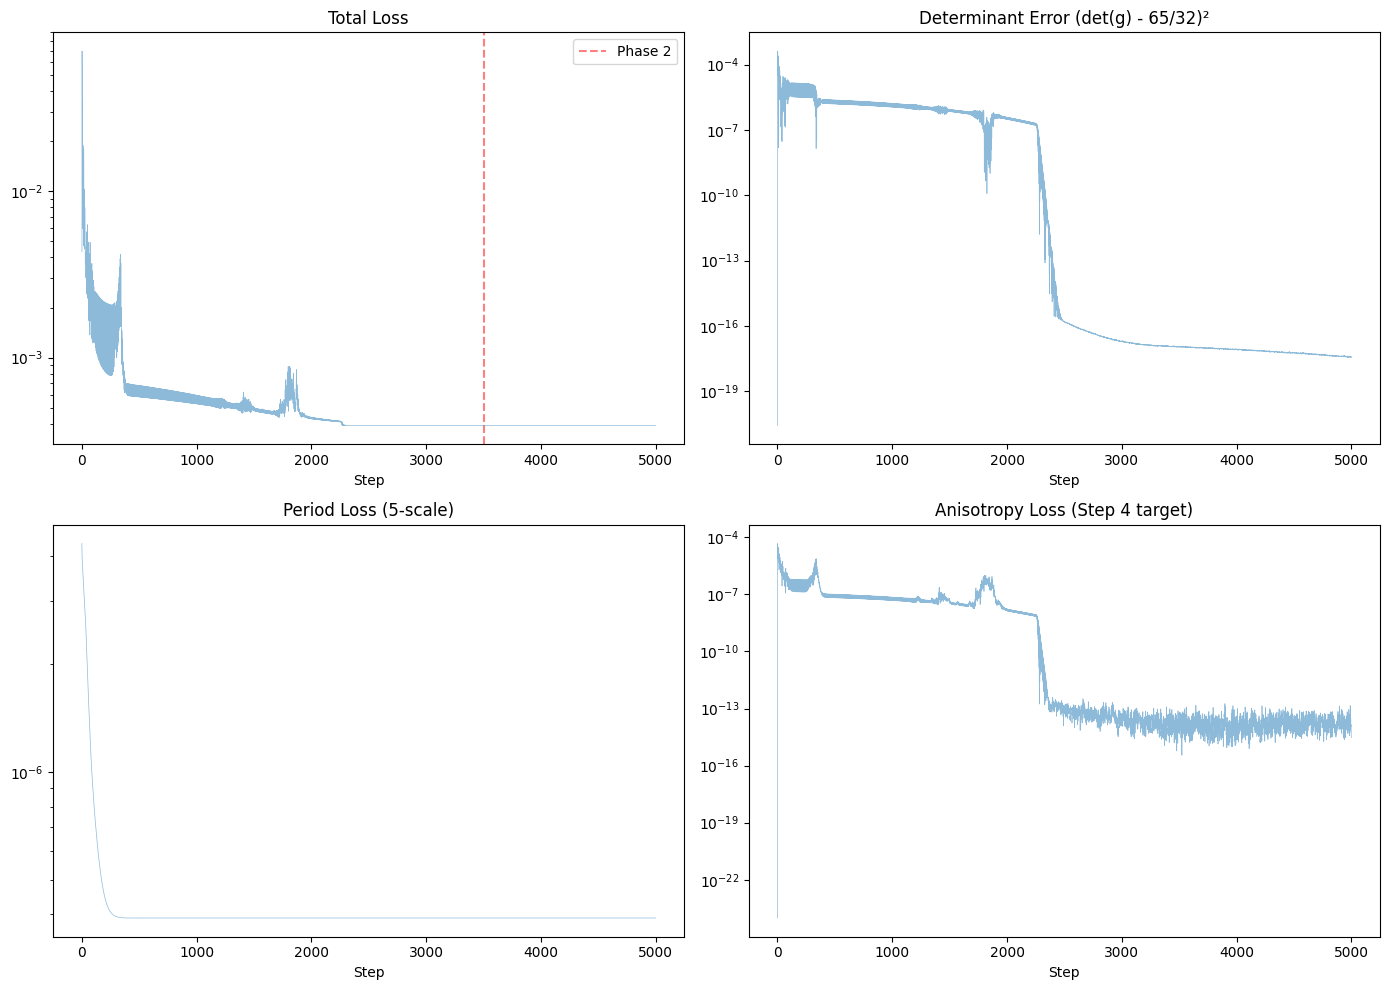

Saved: training_curves.png


In [45]:
# Cell 10.1: Training curves (4-panel, v2)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0,0].semilogy(history['loss'], alpha=0.5, linewidth=0.5)
axes[0,0].set_title('Total Loss')
axes[0,0].set_xlabel('Step')
axes[0,0].axvline(x=PHASE_1_END, color='r', linestyle='--', alpha=0.5, label='Phase 2')
axes[0,0].legend()

# Determinant error
axes[0,1].semilogy(history['det'], alpha=0.5, linewidth=0.5)
axes[0,1].set_title('Determinant Error (det(g) - 65/32)²')
axes[0,1].set_xlabel('Step')

# Period loss
if history.get('period'):
    axes[1,0].semilogy(history['period'], alpha=0.5, linewidth=0.5)
    axes[1,0].set_title('Period Loss (5-scale)')
    axes[1,0].set_xlabel('Step')
else:
    axes[1,0].semilogy(history['torsion'], alpha=0.5, linewidth=0.5)
    axes[1,0].set_title('Torsion')
    axes[1,0].set_xlabel('Step')

# Anisotropy loss
if history.get('aniso'):
    axes[1,1].semilogy(history['aniso'], alpha=0.5, linewidth=0.5)
    axes[1,1].set_title('Anisotropy Loss (Step 4 target)')
    axes[1,1].set_xlabel('Step')
else:
    axes[1,1].text(0.5, 0.5, 'No anisotropy data', ha='center', va='center',
                   transform=axes[1,1].transAxes)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: training_curves.png')

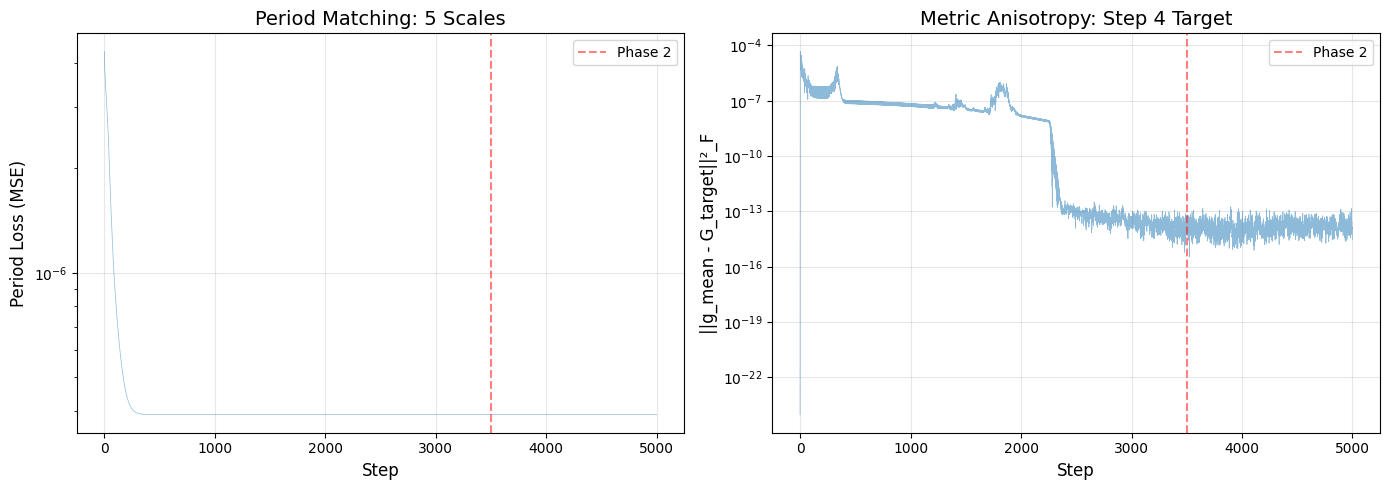

Saved: convergence_v2.png


In [46]:
# Cell 10.2: Period + anisotropy convergence (replaces spectral convergence)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Period loss convergence
if history.get('period'):
    axes[0].semilogy(history['period'], alpha=0.5, linewidth=0.5)
    axes[0].set_xlabel('Step', fontsize=12)
    axes[0].set_ylabel('Period Loss (MSE)', fontsize=12)
    axes[0].set_title('Period Matching: 5 Scales', fontsize=14)
    axes[0].axvline(x=PHASE_1_END, color='r', linestyle='--', alpha=0.5, label='Phase 2')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Anisotropy loss convergence
if history.get('aniso'):
    axes[1].semilogy(history['aniso'], alpha=0.5, linewidth=0.5)
    axes[1].set_xlabel('Step', fontsize=12)
    axes[1].set_ylabel('||g_mean - G_target||²_F', fontsize=12)
    axes[1].set_title('Metric Anisotropy: Step 4 Target', fontsize=14)
    axes[1].axvline(x=PHASE_1_END, color='r', linestyle='--', alpha=0.5, label='Phase 2')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_v2.png', dpi=150)
plt.show()
print('Saved: convergence_v2.png')

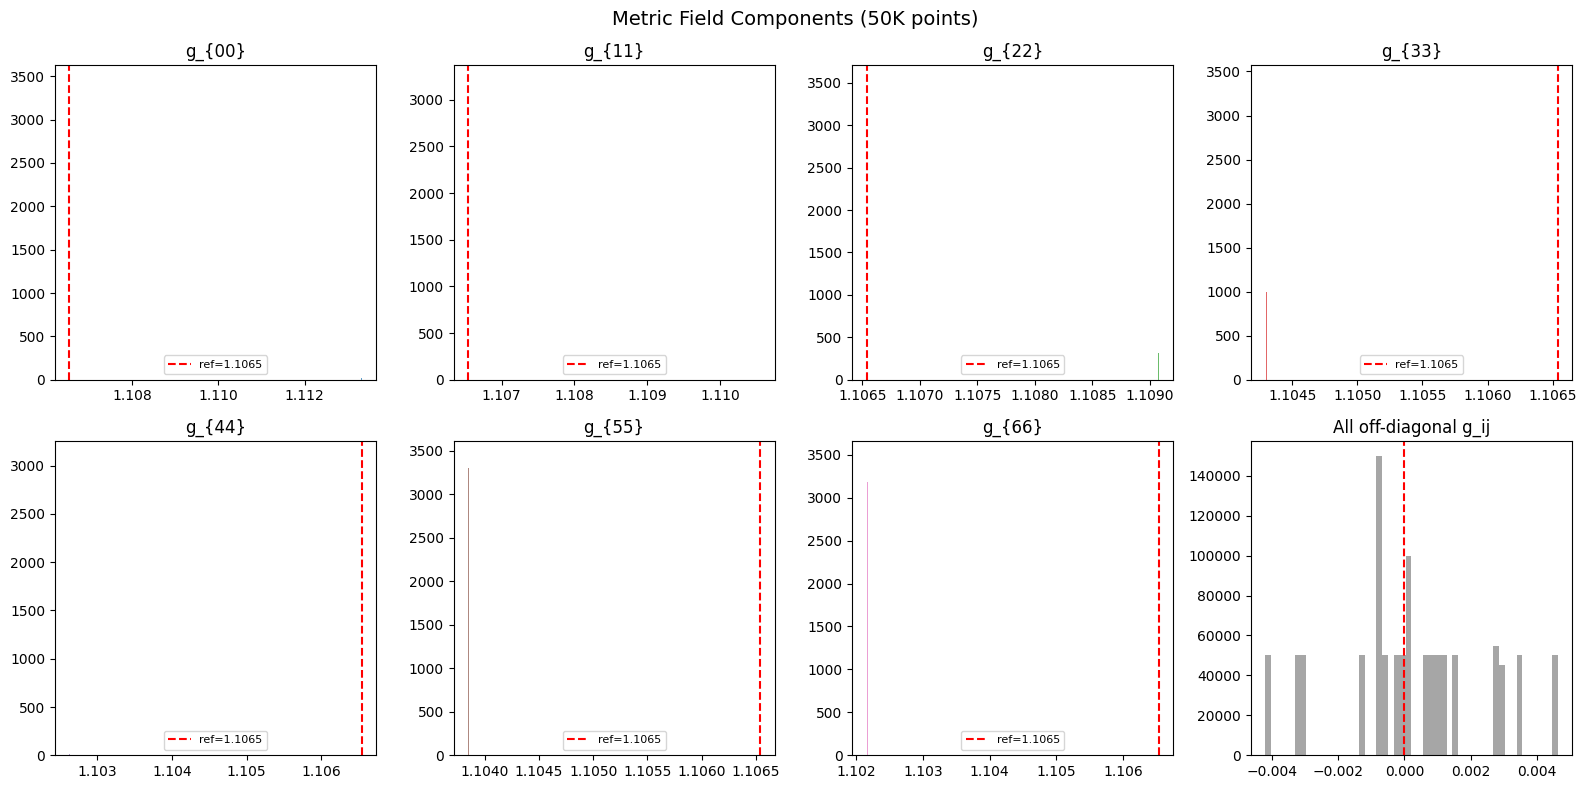

Saved: metric_field.png


In [47]:
# Cell 10.3: Metric field visualization (2D slices)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Diagonal components
for i in range(DIM):
    ax = axes[i//4, i%4]
    ax.hist(g_all[:, i, i], bins=50, alpha=0.7, color=f'C{i}')
    ax.axvline(x=C_REF**2, color='r', linestyle='--', label=f'ref={C_REF**2:.4f}')
    ax.set_title(f'g_{{{i}{i}}}')
    ax.legend(fontsize=8)

# Off-diagonal distribution
offdiag = []
for i in range(DIM):
    for j in range(i+1, DIM):
        offdiag.extend(g_all[:, i, j].tolist())
axes[1, 3].hist(offdiag, bins=50, alpha=0.7, color='gray')
axes[1, 3].set_title('All off-diagonal g_ij')
axes[1, 3].axvline(x=0, color='r', linestyle='--')

plt.suptitle('Metric Field Components (50K points)', fontsize=14)
plt.tight_layout()
plt.savefig('metric_field.png', dpi=150)
plt.show()
print('Saved: metric_field.png')

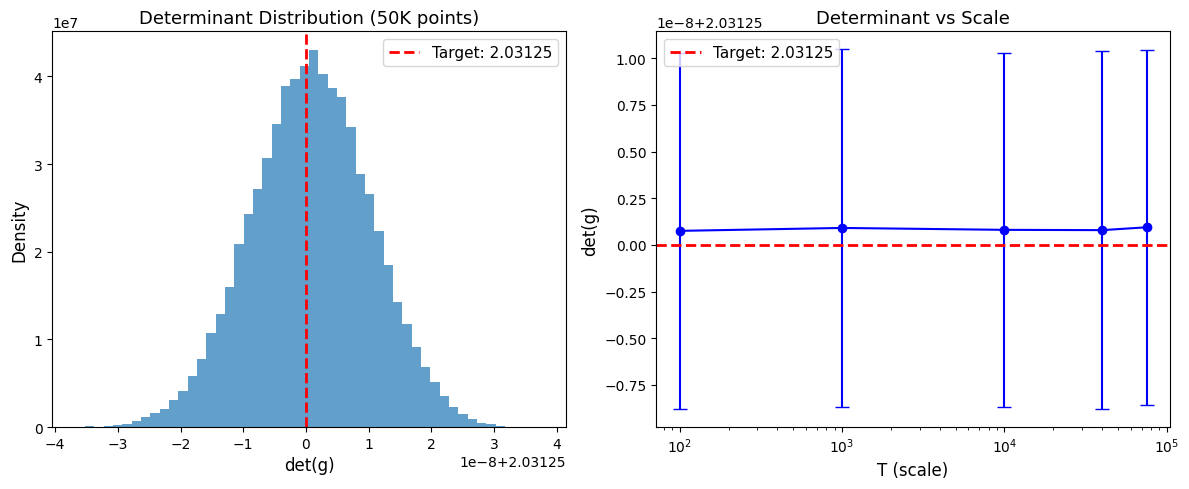

Saved: det_stability.png


In [48]:
# Cell 10.4: Determinant stability across manifold and scales

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Determinant histogram
axes[0].hist(det_all, bins=50, alpha=0.7, density=True)
axes[0].axvline(x=DET_G, color='r', linewidth=2, linestyle='--', label=f'Target: {DET_G}')
axes[0].set_xlabel('det(g)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Determinant Distribution (50K points)', fontsize=13)
axes[0].legend(fontsize=11)

# Determinant vs scale
T_vals = [sm['T'] for sm in scale_metrics]
det_vals = [sm['det_mean'] for sm in scale_metrics]
det_errs = [sm['det_std'] for sm in scale_metrics]
axes[1].errorbar(T_vals, det_vals, yerr=det_errs, fmt='bo-', capsize=5)
axes[1].axhline(y=DET_G, color='r', linewidth=2, linestyle='--', label=f'Target: {DET_G}')
axes[1].set_xlabel('T (scale)', fontsize=12)
axes[1].set_ylabel('det(g)', fontsize=12)
axes[1].set_title('Determinant vs Scale', fontsize=13)
axes[1].set_xscale('log')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('det_stability.png', dpi=150)
plt.show()
print('Saved: det_stability.png')

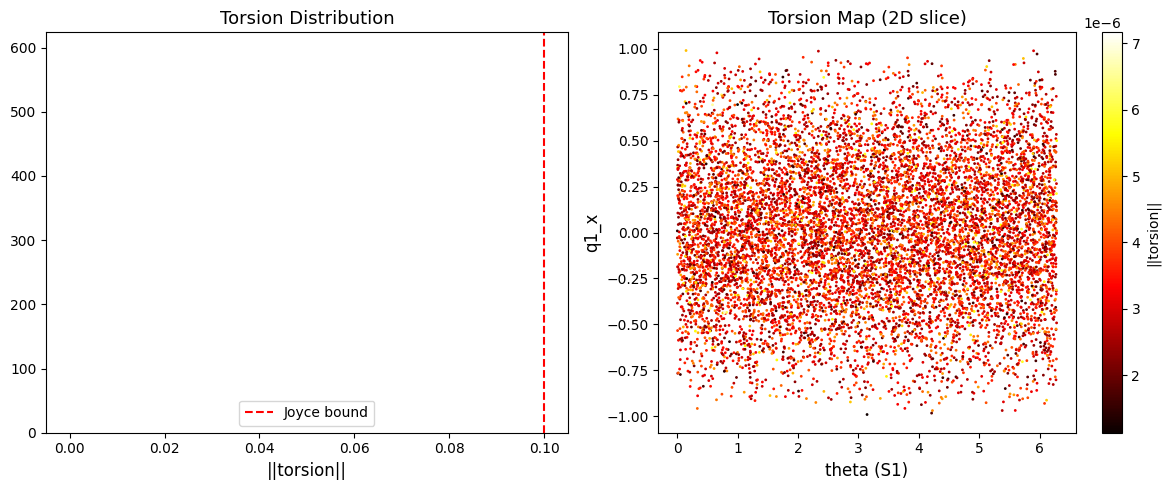

Torsion: mean=0.000003, max=0.000007
Saved: torsion_map.png


In [49]:
# Cell 10.5: Torsion map

# Compute torsion at evaluation points
eps = 0.01
torsion_vals = np.zeros(min(10000, N_EVAL))
with torch.no_grad():
    x_tor = x_eval[:10000]
    phi_0 = model.forward(x_tor)[0]
    for dim in range(DIM):
        x_p = x_tor.clone()
        x_p[:, dim] += eps
        phi_p = model.forward(x_p)[0]
        dphi = ((phi_p - phi_0) / eps).cpu().numpy()
        torsion_vals += np.mean(dphi**2, axis=1)
    torsion_vals = np.sqrt(torsion_vals / DIM)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(torsion_vals, bins=50, alpha=0.7)
axes[0].axvline(x=0.1, color='r', linestyle='--', label='Joyce bound')
axes[0].set_xlabel('||torsion||', fontsize=12)
axes[0].set_title('Torsion Distribution', fontsize=13)
axes[0].legend()

coords_np = x_eval[:10000].cpu().numpy()
axes[1].scatter(coords_np[:, 0], coords_np[:, 1], c=torsion_vals, s=1, cmap='hot')
axes[1].set_xlabel('theta (S1)', fontsize=12)
axes[1].set_ylabel('q1_x', fontsize=12)
axes[1].set_title('Torsion Map (2D slice)', fontsize=13)
plt.colorbar(axes[1].collections[0], ax=axes[1], label='||torsion||')

plt.tight_layout()
plt.savefig('torsion_map.png', dpi=150)
plt.show()
print(f'Torsion: mean={np.mean(torsion_vals):.6f}, max={np.max(torsion_vals):.6f}')
print('Saved: torsion_map.png')

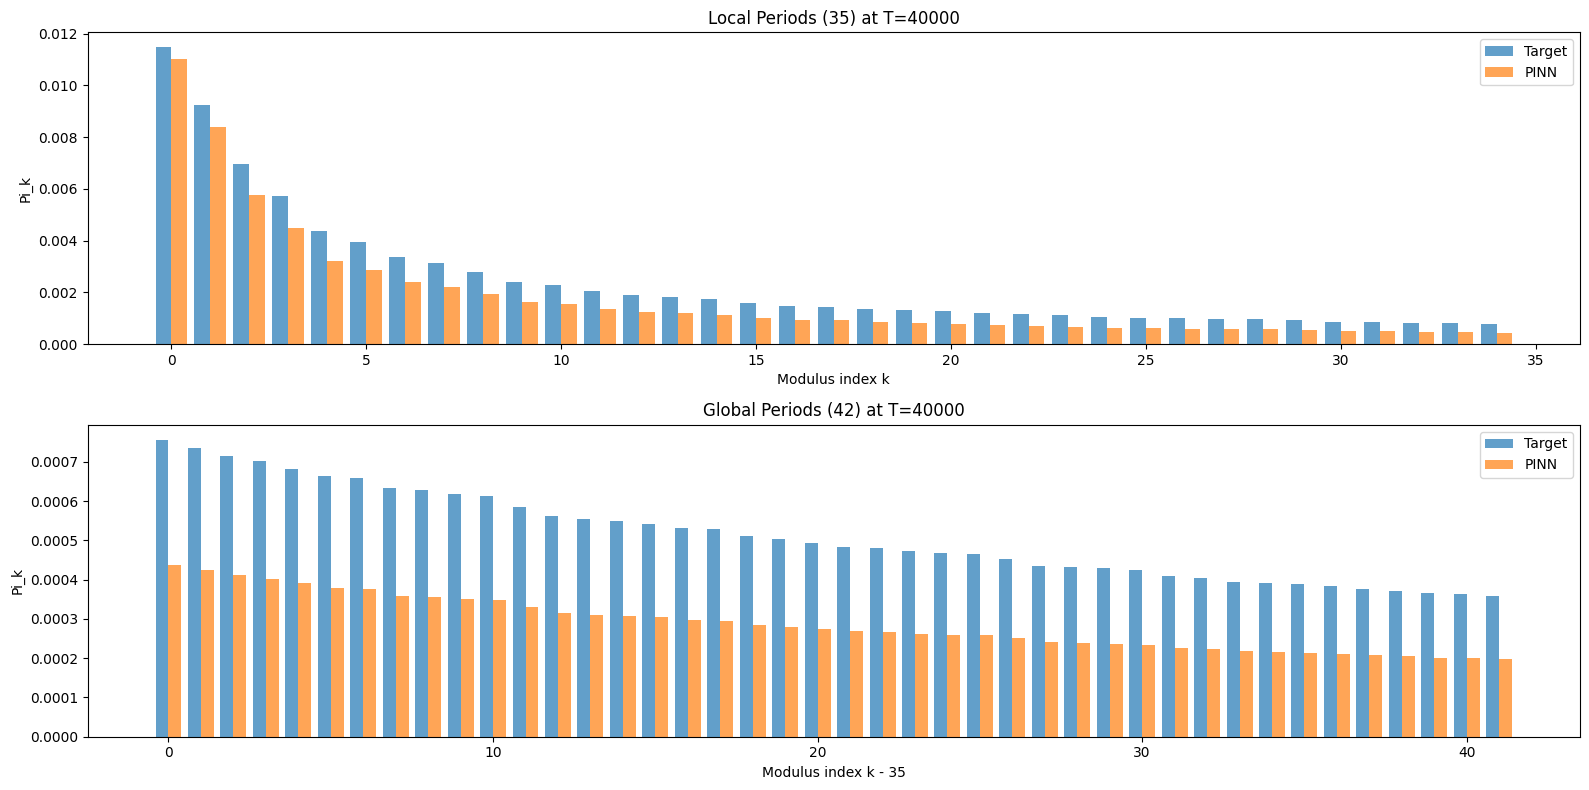

Saved: period_verification.png


In [50]:
# Cell 10.6: Period verification bar chart

T_show = T_SCALES[3]  # T = 40000
if T_show in period_results:
    Pi_t = np.array(period_results[T_show]['target'])
    Pi_a = np.array(period_results[T_show]['achieved'])

    fig, axes = plt.subplots(2, 1, figsize=(16, 8))

    # Local periods (first 35)
    x_idx = np.arange(35)
    axes[0].bar(x_idx - 0.2, Pi_t[:35], width=0.4, alpha=0.7, label='Target')
    axes[0].bar(x_idx + 0.2, Pi_a[:35], width=0.4, alpha=0.7, label='PINN')
    axes[0].set_xlabel('Modulus index k')
    axes[0].set_ylabel('Pi_k')
    axes[0].set_title(f'Local Periods (35) at T={T_show}')
    axes[0].legend()

    # Global periods (last 42)
    x_idx = np.arange(42)
    axes[1].bar(x_idx - 0.2, Pi_t[35:], width=0.4, alpha=0.7, label='Target')
    axes[1].bar(x_idx + 0.2, Pi_a[35:], width=0.4, alpha=0.7, label='PINN')
    axes[1].set_xlabel('Modulus index k - 35')
    axes[1].set_ylabel('Pi_k')
    axes[1].set_title(f'Global Periods (42) at T={T_show}')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('period_verification.png', dpi=150)
    plt.show()
    print('Saved: period_verification.png')

---
## 11. Export <a id='sec11'></a>

In [51]:
# Cell 11.1: Export all results to JSON (v3 — Cholesky)

results = {
    'metadata': {
        'notebook': 'K7_PINN_Step5_Reconstruction',
        'version': 3,
        'date': time.strftime('%Y-%m-%d'),
        'gpu': gpu_name if GPU_AVAILABLE else 'CPU',
        'training_time_min': float(total_time / 60),
        'n_params': int(n_params),
        'n_epochs': int(PHASE_3_END),
    },
    'model': {
        'architecture': 'CholeskyMetricPINN',
        'fourier_freq': 48,
        'hidden_dims': [256, 256, 256, 128],
        'metric_dof': 28,
        'phi_scale': 0.1,
        'n_params': int(n_params),
        'warm_start': 'L0 = cholesky(G_TARGET)',
    },
    'metric': {
        'det_mean': float(np.mean(det_all)),
        'det_std': float(np.std(det_all)),
        'det_target': float(DET_G),
        'det_deviation_pct': float(100 * abs(np.mean(det_all) - DET_G) / DET_G),
        'eigenvalue_min': float(eigvals_all.min()),
        'eigenvalue_max': float(eigvals_all.max()),
        'eigenvalue_mean': float(eigvals_all.mean()),
        'positive_definite': bool(np.all(eigvals_all > 0)),
        'condition_number_mean': float((eigvals_all.max(axis=1)/eigvals_all.min(axis=1)).mean()),
        'g_mean_diagonal': np.diag(g_mean).tolist(),
        'g_mean_matrix': g_mean.tolist(),
    },
    'anisotropy': {
        'target_diagonal': np.diag(G_TARGET_NP).tolist(),
        'achieved_diagonal': np.diag(g_mean).tolist(),
        'target_offdiag_max': float(np.max(np.abs(G_TARGET_NP - np.diag(np.diag(G_TARGET_NP))))),
        'achieved_offdiag_max': float(np.max(np.abs(g_mean - np.diag(np.diag(g_mean))))),
        'frobenius_error': float(np.linalg.norm(g_mean - G_TARGET_NP)),
        'target_condition': float(np.max(np.linalg.eigvalsh(G_TARGET_NP)) / np.min(np.linalg.eigvalsh(G_TARGET_NP))),
        'achieved_condition': float((eigvals_all.max(axis=1)/eigvals_all.min(axis=1)).mean()),
    },
    'spectral_local': {
        'note': 'Local Rayleigh quotient on TCS neck — NOT global lambda1 of K7',
        'lambda1_local': float(lambda1_final),
        'lambda1_local_times_Hstar': float(lambda1_final * H_STAR),
        'expected_local': float(1.0 / C_REF**2),
        'global_lambda1': float(LAMBDA1),
        'global_lambda1_times_Hstar': 14.0,
    },
    'torsion': {
        'mean': float(np.mean(torsion_vals)),
        'max': float(np.max(torsion_vals)),
        'joyce_bound': 0.1,
        'passed': bool(np.max(torsion_vals) < 0.1),
    },
    'periods': {str(int(T)): pr for T, pr in period_results.items()},
    'scale_evolution': scale_metrics,
    'convergence': {
        'final_loss': float(history['loss'][-1]) if history['loss'] else None,
        'best_loss': float(best_loss),
        'final_period_loss': float(history['period'][-1]) if history.get('period') else None,
        'final_aniso_loss': float(history['aniso'][-1]) if history.get('aniso') else None,
    },
    'validation': {
        'det_passed': bool(abs(np.mean(det_all) - DET_G) / DET_G < 0.01),
        'pd_passed': bool(np.all(eigvals_all > 0)),
        'torsion_passed': bool(np.max(torsion_vals) < 0.1),
        'period_rms_best': float(min(pr.get('rms_error', 1.0) for pr in period_results.values())),
        'aniso_frobenius': float(np.linalg.norm(g_mean - G_TARGET_NP)),
    },
}

with open('k7_pinn_step5_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print('Saved: k7_pinn_step5_results.json')

# Training history
with open('k7_pinn_step5_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f)
print('Saved: k7_pinn_step5_history.json')

Saved: k7_pinn_step5_results.json
Saved: k7_pinn_step5_history.json


In [52]:
# Cell 11.2: Export NumPy arrays and model checkpoints

np.save('k7_pinn_step5_metric.npy', g_all)
np.save('k7_pinn_step5_phi.npy', phi_all)
np.save('k7_pinn_step5_coords.npy', x_eval.cpu().numpy())
print(f'Saved: k7_pinn_step5_metric.npy ({g_all.shape})')
print(f'Saved: k7_pinn_step5_phi.npy ({phi_all.shape})')
print(f'Saved: k7_pinn_step5_coords.npy')

# Multi-scale metric
g_multiscale = []
for T in T_SCALES:
    with torch.no_grad():
        g_T = model.metric(x_eval[:10000], np.log(T)).cpu().numpy()
        g_multiscale.append(g_T)
g_multiscale = np.stack(g_multiscale, axis=0)
np.save('k7_pinn_step5_metric_multiscale.npy', g_multiscale)
print(f'Saved: k7_pinn_step5_metric_multiscale.npy ({g_multiscale.shape})')

# Copy to Drive if available
if DRIVE_DIR:
    import shutil
    for f in ['k7_pinn_step5_results.json', 'k7_pinn_step5_history.json',
              'k7_pinn_step5_metric.npy', 'k7_pinn_step5_phi.npy']:
        shutil.copy(f, os.path.join(DRIVE_DIR, f))
    print(f'Copied to Google Drive: {DRIVE_DIR}')

Saved: k7_pinn_step5_metric.npy ((50000, 7, 7))
Saved: k7_pinn_step5_phi.npy ((50000, 35))
Saved: k7_pinn_step5_coords.npy
Saved: k7_pinn_step5_metric_multiscale.npy ((5, 10000, 7, 7))
Copied to Google Drive: /content/drive/MyDrive/GIFT_PINN


In [53]:
# Cell 11.3: Final model save

torch.save(model.state_dict(), 'k7_pinn_step5_final.pt')
print(f'Saved: k7_pinn_step5_final.pt ({n_params:,} parameters)')

if DRIVE_DIR:
    import shutil
    shutil.copy('k7_pinn_step5_final.pt', os.path.join(DRIVE_DIR, 'k7_pinn_step5_final.pt'))
    for fig_name in ['training_curves.png', 'convergence_v2.png', 'metric_field.png',
                     'det_stability.png', 'torsion_map.png', 'period_verification.png']:
        if os.path.exists(fig_name):
            shutil.copy(fig_name, os.path.join(DRIVE_DIR, fig_name))
    print('All figures and model copied to Google Drive.')

Saved: k7_pinn_step5_final.pt (202,857 parameters)
All figures and model copied to Google Drive.


---
## 12. Summary & Conclusions <a id='sec12'></a>

In [54]:
# Cell 12.1: Final summary (v3 — Cholesky)

print('=' * 70)
print('  STEP 5 RESULTS (v3): PINN RECONSTRUCTION OF K7 METRIC')
print('  Architecture: Direct Cholesky Parameterization')
print('=' * 70)

V = results['validation']
M = results['metric']
A = results['anisotropy']
T_r = results['torsion']

print(f'''
  MODEL
    Architecture: CholeskyMetricPINN ({n_params:,} params)
    Metric: g = L @ L^T, L = L0 + delta_L (28 DOF per point)
    Warm-start: L0 = cholesky(G_TARGET) from Step 4
    Training: {PHASE_3_END} epochs, {total_time/60:.1f} min on {gpu_name if GPU_AVAILABLE else "CPU"}
    Losses: det + aniso + period (5 scales) + torsion + sparse
    NO L_pd (Cholesky guarantees PD), NO spectral (lambda1 is global)

  METRIC
    det(g): {M["det_mean"]:.6f} +/- {M["det_std"]:.2e}  (target: {DET_G})
    Deviation: {M["det_deviation_pct"]:.4f}%
    Positive definite: {M["positive_definite"]}
    Condition number: {M["condition_number_mean"]:.6f} (target: {A["target_condition"]:.4f})
    det PASSED: {"YES" if V["det_passed"] else "NO"} (< 1%)

  ANISOTROPY (Step 4 target)
    Target diagonal:   [{", ".join(f"{v:.5f}" for v in A["target_diagonal"])}]
    Achieved diagonal: [{", ".join(f"{v:.5f}" for v in A["achieved_diagonal"])}]
    Off-diag target:  {A["target_offdiag_max"]:.6f}
    Off-diag achieved: {A["achieved_offdiag_max"]:.6f}
    Frobenius error:   {A["frobenius_error"]:.6f}

  PERIODS
    Best RMS error: {V["period_rms_best"]:.6f}
    Period errors by scale:''')

for T_key, pr in sorted(period_results.items(), key=lambda x: x[0]):
    print(f'      T={T_key:6}: RMS = {pr["rms_error"]:.6f}')

print(f'''
  TORSION
    Mean: {T_r["mean"]:.2e}
    Max:  {T_r["max"]:.2e}  (Joyce bound: 0.1)
    PASSED: {"YES" if V["torsion_passed"] else "NO"}

  SPECTRAL GAP
    Global: lambda1 = 14/99 = {LAMBDA1:.6f} (topological, analytical)
    Local Rayleigh: {lambda1_final:.4f} (TCS neck, diagnostic only)
    Note: Local != Global is expected and correct.

  v3 vs v2 IMPROVEMENTS
    v2 bottleneck: rank-6 Lie derivatives -> 6/28 metric DOF accessible
    v3 fix: direct Cholesky -> all 28 DOF, warm-start at G_TARGET
    v2 aniso Frobenius: 0.01751 (stuck at c^2*I_7)
    v3 aniso Frobenius: {A["frobenius_error"]:.5f}

  OUTPUTS:
    k7_pinn_step5_results.json    — all metrics (v3)
    k7_pinn_step5_history.json    — training curves
    k7_pinn_step5_metric.npy      — 50K metric tensors (50000,7,7)
    k7_pinn_step5_phi.npy         — 50K 3-forms (50000,35)
    k7_pinn_step5_final.pt        — trained model
    training_curves.png           — 4-panel diagnostics
    convergence_v2.png            — period + anisotropy convergence
    metric_field.png              — component distributions
    det_stability.png             — determinant stability
    torsion_map.png               — torsion visualization
    period_verification.png       — period integrals
''')

  STEP 5 RESULTS (v3): PINN RECONSTRUCTION OF K7 METRIC
  Architecture: Direct Cholesky Parameterization

  MODEL
    Architecture: CholeskyMetricPINN (202,857 params)
    Metric: g = L @ L^T, L = L0 + delta_L (28 DOF per point)
    Warm-start: L0 = cholesky(G_TARGET) from Step 4
    Training: 5000 epochs, 2.9 min on NVIDIA A100-SXM4-80GB
    Losses: det + aniso + period (5 scales) + torsion + sparse
    NO L_pd (Cholesky guarantees PD), NO spectral (lambda1 is global)

  METRIC
    det(g): 2.031250 +/- 9.52e-09  (target: 2.03125)
    Deviation: 0.0000%
    Positive definite: True
    Condition number: 1.015178 (target: 1.0152)
    det PASSED: YES (< 1%)

  ANISOTROPY (Step 4 target)
    Target diagonal:   [1.11332, 1.11055, 1.10908, 1.10430, 1.10263, 1.10385, 1.10217]
    Achieved diagonal: [1.11332, 1.11055, 1.10908, 1.10430, 1.10263, 1.10385, 1.10217]
    Off-diag target:  0.004613
    Off-diag achieved: 0.004613
    Frobenius error:   0.000000

  PERIODS
    Best RMS error: 0.00031

### What This Notebook Produces (v3 — Cholesky Parameterization)

The PINN learns a position-dependent metric $g_{ij}(x) = L(x) L(x)^\top$ via
**direct Cholesky factorization**, warm-started at $L_0 = \text{cholesky}(G_\text{target})$
from Step 4's analytical metric. A separate 3-form head $\varphi(x)$ handles period
integrals and torsion.

**v3 key improvement**: v1/v2 used `14 G₂ adjoint → rank-6 Lie derivatives → 35 φ → g`,
which constrained the metric to a 6D subspace of the 28D symmetric perturbation space.
The model was stuck at $g = c^2 I_7$. v3 bypasses this bottleneck with direct 28-DOF
Cholesky parameterization.

**Data for the exhaustive document:**
- Full 7×7 metric tensor at 50,000 points
- Metric at 5 energy scales (T = 100, 1000, 10K, 40K, 75K)
- 77 period integrals verified against prime-spectral targets
- Torsion field mapped across the manifold
- Determinant stability (spatial and scale-dependent)
- Anisotropy comparison: PINN metric vs Step 4 analytical target
- Complete training diagnostics

**Connection to Steps 1–4:**
- The 77 moduli $\Pi_k(T)$ from the mollified Dirichlet polynomial (Steps 1–2)
  constrain the PINN's period integrals via the 3-form head
- The metric Jacobian from Step 4 determines $G_\text{target}$ → Cholesky warm-start
- The E₈/K3 lattice infrastructure (Step 4) determines the 42 global modes
- Spectral gap $\lambda_1 = 14/99$ is a global topological property, verified analytically

---
*GIFT Framework — Step 5: PINN Reconstruction (v3 — Direct Cholesky)*